# Ticketsimulation in an online queue

Sarah Leugner 
Semanur Asalioglu

**We have used only fictious numbers for the code.**
Our Code simulates the sale of tickets for a concert in an online queue and calculates: 
- The probability that tickets are still available
- The most important cutoff positions
- And creates a graphical represantation of ticket availability

In [1]:
"""
Monte-Carlo-Simulation of an online concert ticket queue.

The script simulates how tickets are sold in an online queue, 
estimates the probability of still getting a ticket at a given queue position, 
and identifies critical cutoff positions.

"""

'\nMonte-Carlo-Simulation of an online concert ticket queue.\n\nThe script simulates how tickets are sold in an online queue, \nestimates the probability of still getting a ticket at a given queue position, \nand identifies critical cutoff positions.\n\n'

## Imports 
- `numpy` for numerical calculations
- `pandas` for our table
- `matplotlib` for our plot

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


print("Program starts running")

Program starts running


## Simulation parameters
- `TOTAL_TICKETS`: Number of tickets available in the stadium
- `QUEUE-SIZE`: Number of people in the queue
- `SIMULATIONS`: Number of Monte Carlo simulations
- `TICKET_VALUES`&`weights`: Possible ticket qauntites per person and their probabilities 
- `P_ZERO`: Probabilities that a person will not buy tickets

In [3]:
#Parameters
TOTAL_TICKETS=75_000
QUEUE_SIZE=400_000
SIMULATIONS=3_000
TICKET_VALUES=[1,2,3,4]

#Probability for 0 tickets 
P_ZERO=0.05
#5%-Cutoff
CUTOFF_PROB=0.05
#Random generator
rng=np.random.default_rng()


#Ticket distribution 1-4
#Not evenly distributed
#Weight with 1/sqrt(k)
#Expected value = 1.65
ticket_value=np.array([1,2,3,4])
weights=1/np.sqrt(ticket_value)
weights/= weights.sum()

## Single Simulation
Simulates ticket sales for **one queue**: 
- Return: Position of the last person who still gets tickets.
- Each person randomly decides how many tickets to buy (0 to 4, with probabilites).
- The simulation ends as soon as all tickets are sold.
- The function returns the position of the last person who was able to buy a ticket. 

In [4]:
#Single simulation (simulates ticket sales for an online queue when purchasing concert tickets):
def run_single_simulation():
    """
    Simulates a single ticket-selling process.
    
    Each person in the queue attempts to buy between 0 and 4 tickets. 
    The number of available tickets is reduced accordingly.
    When the tickets are sold out, the index of the last person who
    successfully obtained at least one ticket is returned.

    Returns 
    ------
    int 
       Index of the last person who was able to get a ticket.
       If tickets never sell out, returns QUEUE_SIZE.

    """
    tickets_left=TOTAL_TICKETS
    for person in range(QUEUE_SIZE):
        #decides whether the person buys tickets
        if rng.random()<P_ZERO:
            demand=0
        else:
            demand=rng.choice(ticket_value, p=weights)
        tickets_left -=demand
        #Tickets are sold out
        if tickets_left<0:
            #Last person who still gets a ticket
            return person
    return QUEUE_SIZE

## Monte-Carlo-Simulation
The function `run_single_simulation`simulates the queue
- The function `run_single_simulation`is called `SIMULATIONS`times. 
- Calculates **Wahrscheinlichkeit**, that tickets are still available for each position (`p_ticket_left`).

In [5]:
#Monte-Carlo-Simulation
sellout_positions=np.array([run_single_simulation()for _ in range(SIMULATIONS)])

## Probabilities and critical queue positions
We calculate:
- the probability that tickets are still available for each queue position
- the critical point at which the probability of still getting tickets is <5%
- and also the cutoff levels for the various probabilities (50%, 25%, 15%, 10%, 5%, 1%)
We choose a step size of 25 to make the calculations clearer.

In [6]:
#Probability per queue position with step size of 25
positions=np.arange(0, QUEUE_SIZE +1,25)


#Probability that tickets are still available
p_ticket_left = np.mean(sellout_positions[:, None]> positions, axis=0)


#Determine the critical point
#Find the index of the first position where the probability of getting a ticket drops below 5%
critical_idx_candidates = np.where(p_ticket_left < 0.05)[0]
if len(critical_idx_candidates) > 0:
    critical_idx = critical_idx_candidates[0]
else: 
    critical_idx = len(p_ticket_left) - 1 
critical_pos = positions[critical_idx]

#Cutoff-Levels
cutoff_levels = [0.5, 0.25, 0.15, 0.10, 0.05, 0.01]

#Summary-positions (criitcal points for each cutoff Level)
summary_positions = [critical_pos]
for p in cutoff_levels:
    for pos, prob in zip(positions, p_ticket_left):
        if prob < p:
            summary_positions.append(pos)
            break

#Remove duplicates
#(In case the same queue position id added as both a cutoff Level and a critical point)
#This keeps the table and the plot readable and logically correct
summary_positions = sorted(list(set(summary_positions)))

## Table: Probabilities
We show the most important queue positions and use them to create a table showing:
- the queue positions
- the probability that tickets are still available
- and the probability that no tickets are available anymore 


In [7]:
#Table to display probabilities more clearly
summary_indices=[positions.tolist().index(pos) for pos in summary_positions]
table=pd.DataFrame({"Queue-Position":summary_positions, 
                    "P(Ticket available)": [p_ticket_left[i]for i in summary_indices], 
                    "P(No ticket)": [1-p_ticket_left[i]for i in summary_indices]})
#Round values to 3 decimal places 
table["P(Ticket available)"]=table["P(Ticket available)"].round(3)
table["P(No ticket)"]=table["P(No ticket)"].round(3)


#Display only the most important rows 
important_positions = summary_positions
important_rows = table[table["Queue-Position"].isin(important_positions)]


#Cutoff determination
levels = [0.5, 0.25, 0.15, 0.10, 0.05, 0.01]
cutoffs = {}
for p in cutoff_levels:
    for pos, prob in zip(positions, p_ticket_left):
        if prob < p:
            cutoffs[f"{int(p*100)}% Chance"] = pos
            break

## Output Results 
First, all of our initial data should be displayed here so that you can see once again which values form the result.

In [8]:
#Print results
print("\nSimulation completed")
print(f"Stadium tickets: {TOTAL_TICKETS}")
print(f"Simulations: {SIMULATIONS}")
print(f"Queue size: {QUEUE_SIZE}")


Simulation completed
Stadium tickets: 75000
Simulations: 3000
Queue size: 400000


## Sellout-statistics
- Summary of the posititon at which the last tickets were sold.
- Minimum, Median, Quantile, Maximum.

In [9]:
#Sellout statistics
print("\nSellout position:")
print(f"Minimum: {sellout_positions.min():,}")
print(f"5% quantile: {int(np.quantile(sellout_positions, 0.05)):,}")
print(f"Median: {int(np.median(sellout_positions)):,}")
print(f"95% quantile: {int(np.quantile(sellout_positions, 0.95)):,}")
print(f"Maximum: {sellout_positions.max():,}")


Sellout position:
Minimum: 35,401
5% quantile: 35,591
Median: 35,768
95% quantile: 35,943
Maximum: 36,115


## Critical queue positions for different probabilities are displayed.

In [10]:
print("\nCritical queue positions:")
for k, v in cutoffs.items():
    print(f"{k:>10} approx. {v:,}")


Critical queue positions:
50% Chance approx. 35,775
25% Chance approx. 35,850
15% Chance approx. 35,900
10% Chance approx. 35,925
 5% Chance approx. 35,950
 1% Chance approx. 36,025


## Visualization
- Shows the probability of ticket availability in the critical range
- Horizontal lines: Mark the different cutoff levels
- The critical point is also highlighted (~5% Chance of tickets still being available)
- We try to highlight the most relevant aresa of the online queue where tickets are running low. 

C:\Users\sarah\AppData\Local\Temp\ipykernel_10488\2863552918.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


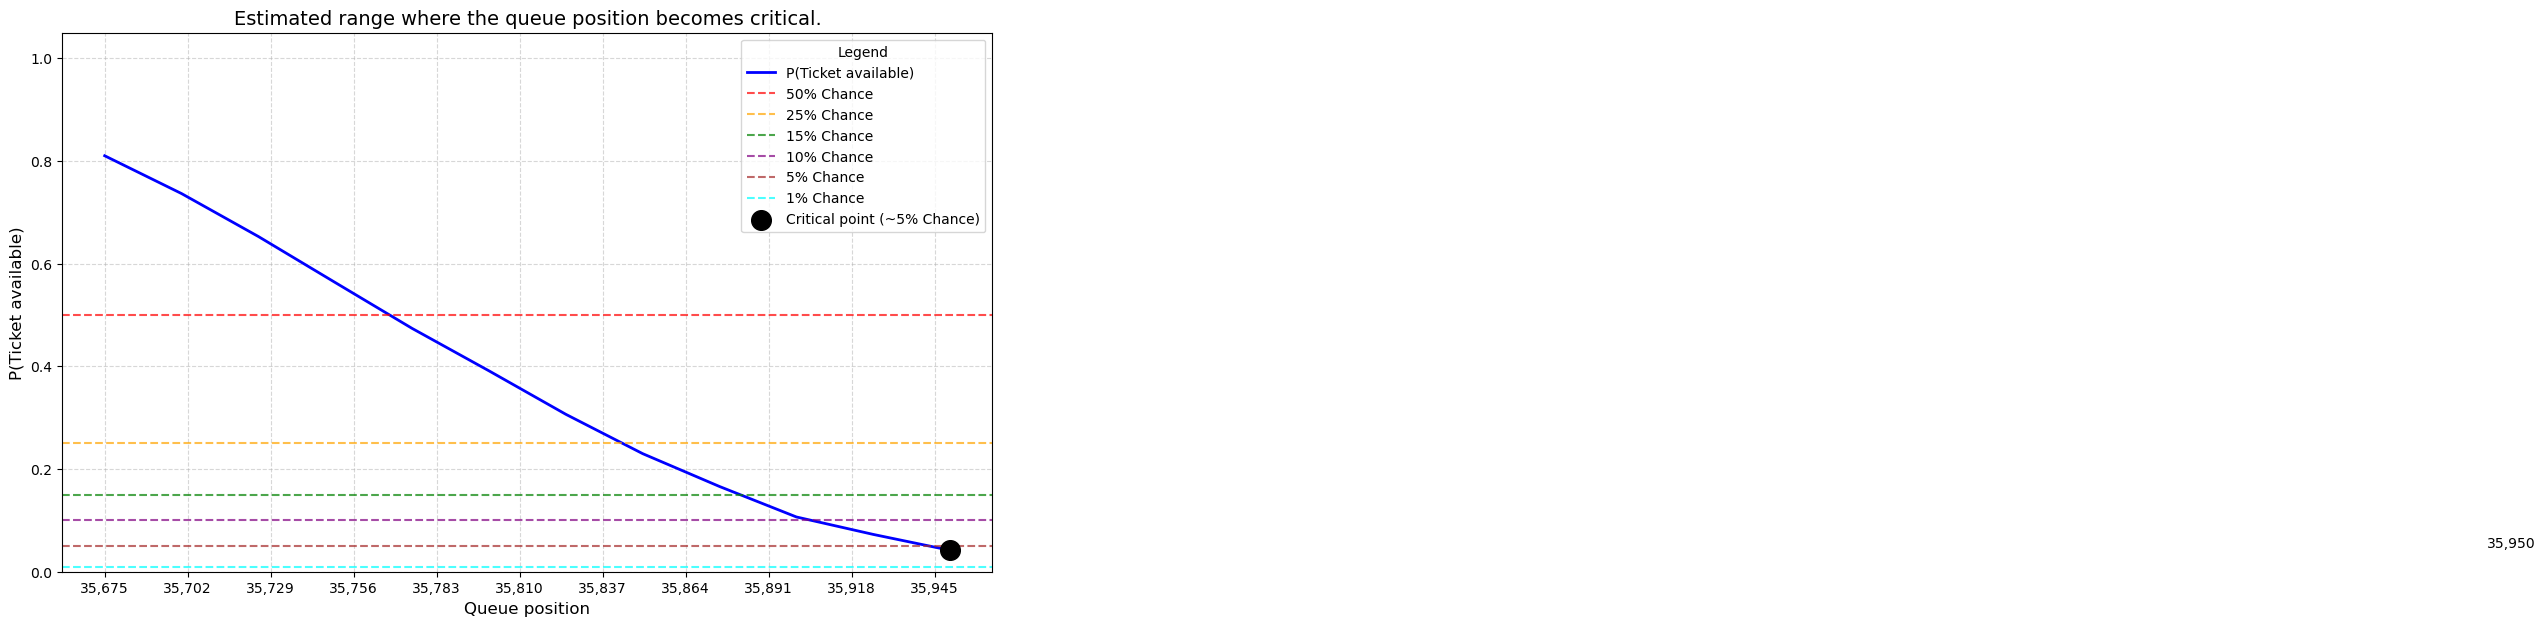

In [11]:
#Plot
#Visualization of the ticket availability probability
low_p = 0.5
high_p = 0.7

#We only want to show the most relevant area
#which highlights where it becomes critical to get a ticket
interesting_idx = np.where((p_ticket_left <= high_p) & (p_ticket_left >= low_p))[0]
if len(interesting_idx)==0:
    ZOOM_MIN = max(0, critical_pos - 500)
    ZOOM_MAX = min (QUEUE_SIZE, critical_pos + 500)
else: 
    ZOOM_MIN = positions[max(0, interesting_idx[0] - 2)]
    ZOOM_MAX = positions[min(len(positions)-1, interesting_idx[-1]+2)]

#Relevant queue positions
mask = (positions >= ZOOM_MIN) & (positions <= ZOOM_MAX)
if critical_pos < ZOOM_MIN:
    ZOOM_MIN = critical_pos
if critical_pos > ZOOM_MAX:
    ZOOM_MAX = critical_pos
mask = (positions >= ZOOM_MIN) & (positions <= ZOOM_MAX)

plt.figure(figsize=(12, 7))

#Main probability line
plt.plot(positions[mask], p_ticket_left[mask], color='blue', linewidth=2, label='P(Ticket available)')

#Horizontale cutoff lines
cutoff_levels = [0.5, 0.25, 0.15, 0.10, 0.05, 0.01]
h_color=['red', 'orange', 'green', 'purple', 'brown', 'cyan']
v_color="darkblue"
for p, c in zip(cutoff_levels, h_color):
        plt.axhline(p, linestyle="--", color=c, alpha=0.7, label=f"{int(p*100)}% Chance")
        

#Mark the critical point
critical_prob = p_ticket_left[critical_idx]
plt.scatter(critical_pos, critical_prob, color='black', s=200, zorder=5, label='Critical point (~5% Chance)')
plt.text(critical_pos+500, critical_prob, f"{critical_pos:,}", fontsize=10, verticalalignment='bottom')

#Axis labels, title, and grid
plt.xlabel("Queue position", fontsize=12)
plt.ylabel("P(Ticket available)", fontsize=12)
plt.title("Estimated range where the queue position becomes critical.", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

#Axis formatting
plt.xticks(np.arange(ZOOM_MIN, ZOOM_MAX+1, max(1,(ZOOM_MAX-ZOOM_MIN)//10)), [f"{x:,}" for x in np.arange(ZOOM_MIN, ZOOM_MAX+1, max(1,(ZOOM_MAX-ZOOM_MIN)//10))])
plt.ylim(0,1.05)
plt.legend(title="Legend")
plt.tight_layout()

plt.savefig("plot_zoom.png")
plt.show()